# [INFO-H515 - Big Data Scalable Analytics](https://uv.ulb.ac.be/course/view.php?id=85246?username=guest)

## TP 6 - Feature selection with Map/Reduce

*Materials originally developed by Yann-Aël Le Borgne and Gianluca Bontempi*

#### *Theo Verhelst, Daniele Lunghi and Gianluca Bontempi*

####  Date: TBD

This class aims at implementing from scratch Map/Reduce solutions for feature selection using filter methods. 

### Class objectives:

* Recall of feature selection approaches
* Synthetic data generation and data visualization
* Feature ranking with correlation. Implementation from scratch using NumPy.
* Implementation of Map/Reduce feature ranking with correlation using Spark.
* Feature ranking with mRMR and correlation. Implementation from scratch using NumPy.
* Implementation of Map/Reduce feature ranking with mRMR and correlation using Spark.


# Introduction 

Feature selection  algorithms  (FSA) form  an  essential  component of  machine  learning  and  data  mining  workflows. Besides reducing a dataset size, FSA also generally allow to improve the  performance  of  classification  and  regression  models  by selecting the most relevant features and reducing the noise in a dataset [1,2]. 

Three  main  classes  of  FSA  can  be  distinguished: filter, wrapper and embedded methods. Filter methods are model-agnostic,  and  rank  features  according  to  some  metric of  information  conservation such  as  correlation or mutual  information.  Wrapper  methods  use  the  model  as  a  black-box to  select  the  most  relevant  features.  Finally,  in  embedded methods, feature evaluation is performed alongside the model training.

Spark provides very limited support for feature selection (see https://spark.apache.org/docs/latest/ml-features).

In this class, we show how to implement two standard feature selection algorithms belonging to filter  methods: simple feature ranking, and Maximum Relevance — Minimum Redundancy (mRMR). For both methods, correlation is used as the metric of information  conservation. 


## Notations

Let us reuse the common notations from the previous classes:

* Let $(x_i,y_i)$, $1 \le i \le N$, be a set of $N$ observations, with $x_i \in \mathbb{R}^n$ and $y_i \in \mathbb{R}$. $x_i$ are the inputs, and $y_i$ the outputs, and $n$ is the number of input features.
* Let $X$ be the matrix of inputs with rows $x_i$, of size $N \times n$ ($N$ observations, (rows) and $n$ features (columns)). 
* Let $X_j \in \mathbb{R}^N$ denote the $j$-th feature, $1 \le j \le n$. 
* Let $Y \in \mathbb{R}^N$ be the vector of outputs $y_i$.

## Data layout

The most common way to organize training data is by designing a table where rows contain observations and columns represent features. This is the $X$ matrix defined above, which we will also refer to as the *conventional* layout. Denoting by $x_{i,j}$ the value for the $j$-th feature of the $i$-th observation, the conventional layout stores data as follows:  


|   |   |   |   |   |
|:---:|---|---|---|---|
| $x_{1,1}$  | $x_{1,2}$  | $...$  | $...$  | $x_{1,n}$ |
| $x_{2,1}$  | $x_{2,2}$  | $...$  | $...$  | $x_{2,n}$ |
| $...$  | $...$  | $...$  | $...$  | $...$  |
| $x_{N,1}$  | $x_{N,2}$  | $...$  | $...$  | $x_{N,n}$ |

Depending on the number of observations and number of features, the data table can be more or less 'short/long' (small or large number of observations), and 'narrow/wide' (small or large number of features). 

It is important to note that Map/Reduce is well-suited for long/narrow (L/N) tables, but much less for short/wide (S/W) tables. The reason is that Map/Reduce divides input data in chunks of rows that are subsequently processed by the mappers.

S/W tables are for example encountered in domains such as text mining or bioinformatics, where the number of features can be on the order of tens or hundreds of thousands, while observations may onlybe on the order of hundreds or thousands. In such cases, it can be beneficial to transform S/W into T/N tables, by storing observations as columns and features as rows. We refer to this type of structure as *featurewise* or *alternative layout*, where data is stored as follows:

|   |   |   |   |   |
|---|---|---|---|---|
| $x_{1,1}$  | $x_{2,1}$  | $...$  | $...$ | $x_{N,1}$ |
| $x_{1,2}$  | $x_{2,2}$  | $...$  | $...$  | $x_{N,2}$ |
| $...$  | $...$  | $...$  | $...$  | $...$  |
| $x_{1,n}$  | $x_{2,n}$  | $...$  | $...$  | $x_{N,n}$ |

The Map/Reduce implementations discussed in this class will rely on the aternative layout, for which the implementations are slightly easier. 



# General imports

Data generation and manipulation will mostly rely on NumPy, SciPy, scikit-learn and Pandas libraries. Data visualization will rely on Matplotlib. Map/Reduce operations will be handled by PySpark.

In [1]:
import time
import os 
import numpy as np
import scipy.stats

import sklearn
import sklearn.datasets

import pandas as pd

%matplotlib notebook  
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark.sql import SparkSession


Details of relevant Spark methods can be found in the [Spark RDD programming guide](https://spark.apache.org/docs/latest/rdd-programming-guide.html#resilient-distributed-datasets-rdds).

# 1) Dataset generation and visualization

Let us start by generating a dataset of synthetic data where input data contains informative but also redudant and noisy features. The goal of our feature selection methods will be to identify informative features and discard noisy ones. 

The dataset is generated by the `generate_dataset` function below. It takes as input

* `n_samples`: Number of observations $N$
* `n_informative`: Number of informative features
* `n_noisy`: Number of noisy features
* `n_redundant`: Number of redundant features
* `random_seed`: A random seed for reproducibility

The function returns a matrix $X$ of size $N \times n$ ($N$ observations, (rows) and $n$ features (columns)), and an output vector $Y$. The total number of features $n$ is the sum of the informative, redundant and noisy features. 

Internally, the function relies on the [`sklearn.datasets.make_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) function for generating a dataset where the output is correlated with the informative features. The `generate_dataset` function further adds redundant features by means of linear combinations of the informative features.  

In [2]:
def generate_dataset(n_samples=100, n_informative=1, n_noisy=2, n_redundant=1, random_seed=0):
    
    # Set random seed
    np.random.seed(random_seed)
    
    # Use sklearn.datasets.make_regression to generate an artificial dataset where the output y 
    # is correlated with a subset of of the input features
    X, Y = sklearn.datasets.make_regression(n_samples=n_samples, 
                                            n_features=n_informative+n_noisy, 
                                            n_informative=n_informative)
    
    # Create a random mixing matrix for generating redundant features from informative ones
    mixing_matrix = np.random.random((n_informative, n_redundant))
    
    # Create redundant features by taking random linear combinations of informative features
    redundant_features = np.dot(X[:,0:n_informative], mixing_matrix)
    
    # Add redundant features to the input data
    X = np.concatenate((X, redundant_features), axis=1)
    
    # Return input data X, output data Y
    return X, Y

Let us for example generate with 100 observations and 2 informative features, 2 noisy features and 2 redundant features (6 features in total).

In [3]:
# Let us generate the dataset
N = 100
n_informative = 2
n_noisy = 2
n_redundant = 2

X, Y = generate_dataset(n_samples=N, 
                        n_informative=n_informative, 
                        n_noisy=n_noisy, 
                        n_redundant=n_redundant)



Let us check the size of the input and output data:

In [4]:
# Input data contains 100 observations and 6 features
X.shape

(100, 6)

In [5]:
# Output data contains 100 values
Y.shape

(100,)

Let us display the first rows of the generated dataset by storing X and Y in a Panda DataFrame.

In [6]:
df = pd.DataFrame(X)
df['Y']=Y
df.head()

,0,1,2,3,4,5,Y
0,-1.157355,-0.312292,-0.157667,2.256723,-0.301750,-1.331027,-34.387918
1,-0.509652,-0.438074,-1.252795,0.777490,-0.355253,-0.856046,-25.412897
2,-0.887786,-1.980796,-0.347912,0.156349,-1.519784,-2.584751,-85.876275
3,0.857924,1.141102,1.466579,0.852552,0.896684,1.803546,56.572129
4,1.364532,-0.689449,-0.652294,-0.521189,-0.426769,0.619462,4.404141


## Data visualization

Let us display the scatter plots between input and output features. Note that it is visually difficult to identify which features are informative (we known that features 0 and 1 are correlated with the the output, though this does not appear clearly in the plots). The redundant features (4 and 5) appear more clearly correlated with the output.

<IPython.core.display.Javascript object>


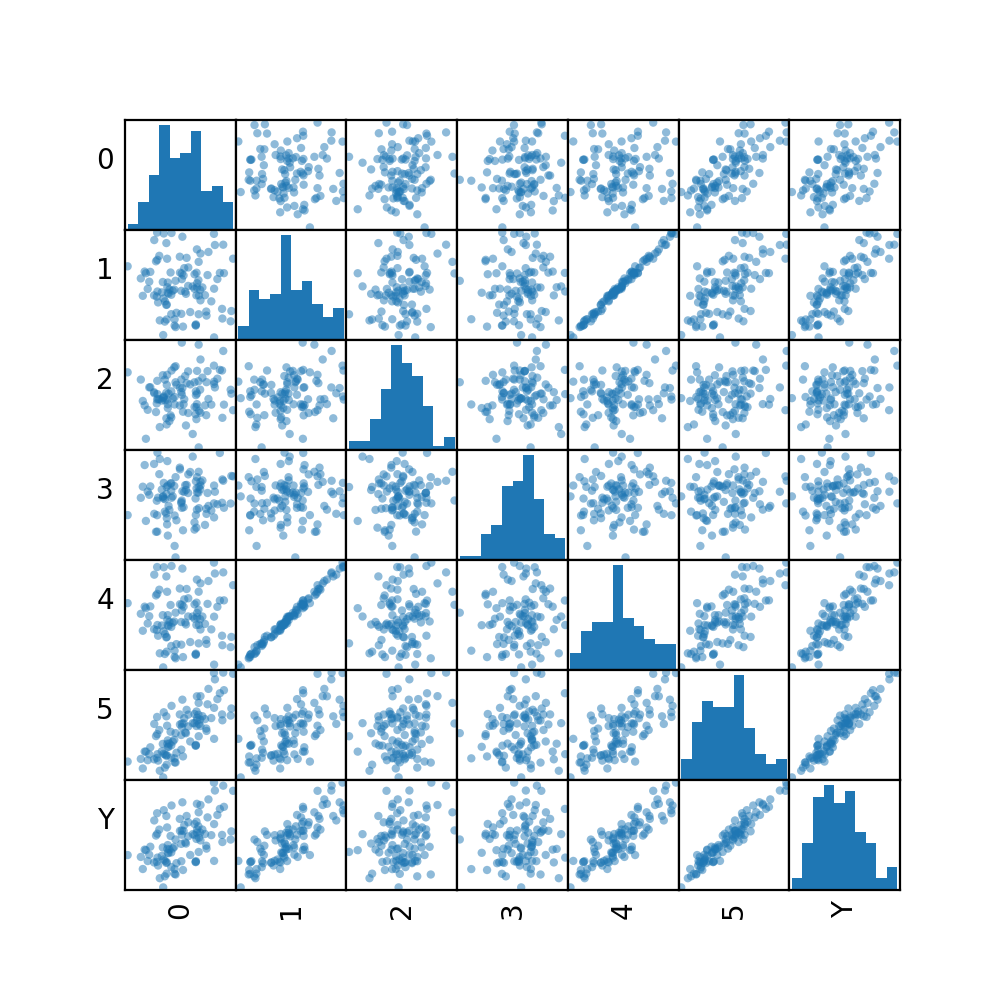

In [7]:
axs = pd.plotting.scatter_matrix(df, figsize=(5, 5));

# Rotate axis labels and remove axis ticks
n = len(df.columns)
for j in range(n):
    v = axs[j, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, j]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Let us use a 3D plot for plotting the output as a function of 2 input features. The linear dependencies between the first two features and the output feature now appear clearly. 

<IPython.core.display.Javascript object>


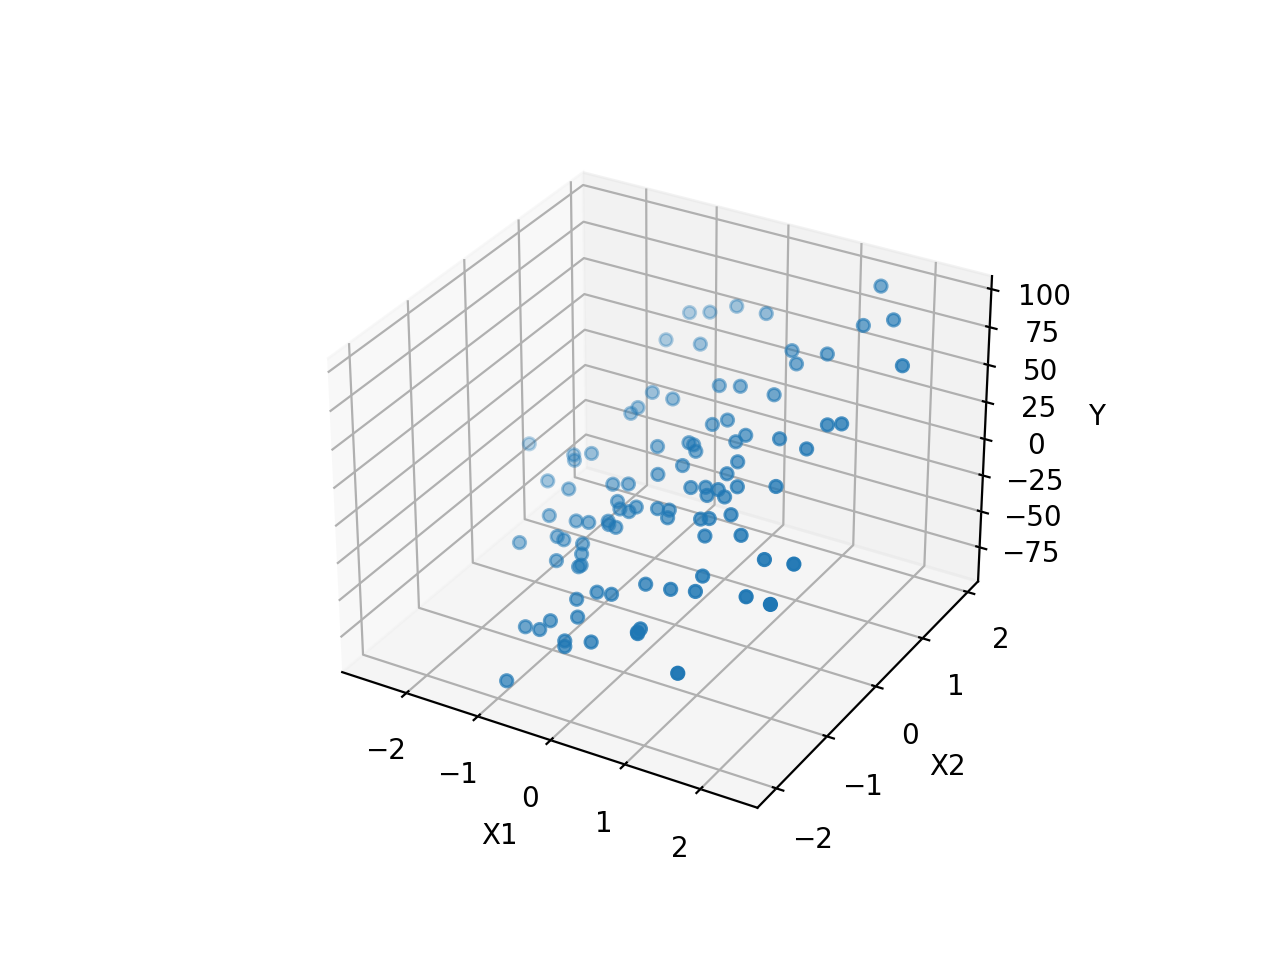

Text(0.5, 0, 'Y')

In [8]:
#Warning: Do not plot if N>1000 !
features_to_plot = [0,1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0:N,features_to_plot[0]],X[0:N,features_to_plot[1]],Y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')


# 2)  Feature ranking with correlation

Let us implement a feature selection method based on feature ranking where correlation is used to select the top $K$ most relevant features. The algorithm is simple, and consists in computing with a loop the correlation between all input features and the output features. The indices of the $K$ features with the highest correlations (in absolute values) are returned. A function `get_score` is used inside the loop to compute the absolute correlation between an input feature and the output.


The algorithm can be summarized as follows::

```
X: Input data
Y: Output data
K: Number of features to select
get_top_K_features(X,Y,K):

    n <- number of features in X
    scores_j_y <- list[n]
    
    # For each input feature
    For j in 1:n
      
      # Get (correlation) score with the output
      scores_j_y[j] <- get_score(X_j, y)

    # Select indices with highest scores
    selected_features_indices <- $K$ indices with highest scores in scores_j_y

    return selected_features_indices

``` 


## 2.1) Centralized approach

Assuming that the training data can be stored on a single computer, a centralized approach with NumPy can be used. 

**Exercises:**

* Write the function `get_top_K_features(X,Y,K)`
* Write the function `get_score(X_j, y)`

Hint: 

* Use NumPy function `argsort` to retrieve the indices with highest scores in scores_j_y
* Use `scipy.stats.pearsonr` to get the correlation coefficient between two vectors


In [9]:
# X: Input data
# Y: Output data
# K: Number of features to select
def get_top_K_features(X,Y,K):

    n = X.shape[1]

    scores_j_y = np.zeros(n)

    for j in range(n):
    
        scores_j_y[j] = get_score(X[:,j], Y)
        
    index_ranked_scores = np.argsort(scores_j_y)
    
    selected_features_indices = index_ranked_scores[-K:][::-1]

    return selected_features_indices

In [10]:
def get_score(x, y):
    
    score = np.abs(scipy.stats.pearsonr(x, y)[0])
    
    return score

Get the 2 most correlated features with the output

In [13]:
selected_features_indices = get_top_K_features(X,Y,K=2)
selected_features_indices

(array([0.5110963 , 0.81898047, 0.25605015, 0.0894027 , 0.86823985,
        0.9624316 ]),
 array([5, 4]))

Note that the two most correlated features are the redundant features.

**Exercises:**

* Modify the `get_top_K_features` so that it also returns the scores for each input features
* Verify that the redundant features were correctly selected. Why were the originally relevant features not selected? 

In [14]:
def get_top_K_features(X,Y,K):

    n = X.shape[1]

    scores_j_y = np.zeros(n)
    
    for j in range(n):
    
        scores_j_y[j] = get_score(X[:,j], Y)
        
    index_ranked_scores = np.argsort(scores_j_y)
    
    selected_features_indices = index_ranked_scores[-K:][::-1]

    return scores_j_y, selected_features_indices

In [15]:
scores_j_y, selected_features_indices = get_top_K_features(X,Y,K=2)
scores_j_y

array([0.5110963 , 0.81898047, 0.25605015, 0.0894027 , 0.86823985,
       0.9624316 ])

The redundant features, which were constructed as linear combinations of the informative features, are more correlated to the target than the original informative features. 

## 2.2) Map/Reduce approach using Spark

Let us now assume that the training data cannot be stored on a single computer, and are stored in a distributed way using for example HDFS. Spark can be used compute the correlations between all input features and the output feature in a distributed way. 

In order to ease the implementation, we will work the alternative data layout $X^T$, referred to as `t_X`.

In [16]:
t_X = np.transpose(X)

The implementation consists in 3 main stages:

* **Stage 1**: Partitioning. Partition `t_X` in $B$ blocks `t_X_b`, $1 \le b \le B$. This can be done by calling the `parallelize` function to create the Spark Resilient Distributed Dataset (RDDs). Y is broadcasted to all workers.
* **Stage 2**: Distributed computation of scores with Map/Reduce. The mappers will take a block $t_X_b$ as input, and output the scores between each feature in `t_X_b` and the output $Y$. $Y$ will be made available to the mapper by using a [broadcast variable](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.Broadcast.html).
* **Stage 3**: Collect scores for all input features, and select the $K$ indices with the highest scores


**Exercise:**

* What will be the sequence of Spark operators to call for these three stages?


Answer:

* For stage 1, `parallelize`, using as input the training dataset and number of partitions
* For stage 2, `map`, where the `get_score` function will be called
* For stage 3, `collect`, to retrieve the results.

The overall chaining of operators can be written as:

```
sc.parallelize(t_X,B).map(get_score_spark).collect()
```


### Start Spark session

Let us create a Spark session and retrieve the `sparkContext` object.

In [17]:
#docker run -v `pwd`:/home/guest/shared -p 8889:8888 -p 4040:4040 -p 23:22 -it bda bash

# Start Spark session with local master and 2 cores
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("FeatureSelection") \
    .getOrCreate()

# Let us retrieve the sparkContext object
sc=spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/02 10:07:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Create RDD with B partitions

The RDD is created by calling the `parallelize` function of the `sparkContext` object.

In [18]:
#Let us use 2 partitions
B=2
X_RDD=sc.parallelize(t_X,B).cache()

Let us check that the number of rows of the RDD corresponds to the number of features.

In [19]:
X_RDD.count()

6

### Broadcast Y and use get_score as the mapper 

Broadcasting a variable can be done by calling the `broadcast` function of the `sparkContext` object (see [here](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.Broadcast.html) for the API reference on broadcast variables). The variable will then be available to all mappers by means of the `broadcast_Y` object.

In [20]:
broadcast_Y = sc.broadcast(Y)

The mapper will consist in computing the correlation scores between each of the row of the incoming block and the output feature Y. Since $Y$ is broadcasted, we can simply have the mapper call `get_score_spark` function.

```
X_RDD.map(get_score_spark)
```


With `get_score_spark` defined as follows:

In [21]:
# Inputs are rows of the incoming block (features X_j)
def get_score_spark(x):
    
    # Get the content of the broadcast_Y object
    y = broadcast_Y.value
    
    # Compute the correlation between input feature x and output feature y
    score = np.abs(scipy.stats.pearsonr(x, y)[0])
    
    # Return correlation score
    return score

The correlations between all input features and the output features can be computed by having the mapper call the `get_score_spark`, and collect the results. 

In [22]:
%time scores_j_y = X_RDD.map(get_score_spark).collect()

CPU times: user 11.6 ms, sys: 8.63 ms, total: 20.3 ms
Wall time: 179 ms


Let us display the computed scores, and check we get the same results as with the NumPy implementation:

In [23]:
scores_j_y

[0.5110963045502195,
 0.8189804709078639,
 0.25605015174172246,
 0.08940269877688763,
 0.868239852504717,
 0.9624316033684382]

Let us finally order the scores by ascending order, adn retrieve the indices of the $K$ most correlated features. The implementation is the same as the NumPy implementation:

In [24]:
K=2

scores_j_y = np.array(scores_j_y)

index_ranked_scores = np.argsort(scores_j_y)
selected_features_indices = index_ranked_scores[-K:][::-1]


The two most correlated features are the 4-th and 5-th features:

In [25]:
selected_features_indices

array([5, 4])

**Exercise:**

* What are the limits of this feature selection method?


Answers: 

* Redundant features can be selected: If two features are exactly the same, and highly correlated with the output, both of them wil be selected. 
* The method may miss features which are informative but have a nonlinear dependency with the output. Other criteria could be used for scoring the variables to detect nonlinear dependencies, such as mutual information. 

# 3)  Feature ranking with mRMR and correlation


The second method proposed here is mRMR (Maximum Relevance — Minimum Redundancy), which aims at avoiding selecting redundant features. mRMR is an iterative method that takes $K$ steps to select the $K$ most relevant features. At each step, the relevance of candidate features is assessed by computing its correlation with the output feature, and subtracting its average correlation with already selected features. The feature with the highest score is added to the set of selected features, and removed from the set of candidate features. After $K$ steps, $K$ features have been selected, which are maximally correlated with the output while being minimally correlated among one another.

The algorithm can be summarized as follows:

```
X: Input data
Y: Output data
K: Number of features to select
get_top_K_features_mRMR(X,Y,K):

    n <- number of features in X
    
    # At first, all features are considered (remaining features contains all indices)
    remaining_features_indices = list[n]
    # and no feature are selected
    selected_features_indices = []

    # Loop for selecting K features iteratively
    For k in 1:K
    
        # Retrieve values of selected features
        selected_features_values <- X[:,selected_features_indices]
        n_remaining_features <- length(remaining_features_indices)
        
        # Set scores for remaining features to 0
        score_r <- list[n_remaining_features]

        # For each remaining feature
        for r in 1:remaining_features_indices:
        
            # Get feature index
            feature_r_index = remaining_features_indices[r]
        
            # Compute mRMR score for that feature
            score_r = get_mrmr_score(X[:,feature_r_index], Y, selected_features_values)
        
            # Store score 
            score_r[r] = score_j
    
        # Select feature index with highest score
        index_max_score_features = np.argmax(score_features)
    
        # Add feature index to selected features
        selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
        # Remove feature index from remaining features
        del(remaining_features_indices[index_max_score_features])
      
    return selected_features_indices

``` 



## 3.1) Centralized approach

Assuming that the training data can be stored on a single computer, a centralized approach with NumPy can be used. 

We follow the same process as in section 2, where we first implement the feature selection loop in a function, called `get_top_K_features_mRMR`. The function follows the steps described in the mRMR algorithm:

In [26]:
# X: Input data
# Y: Output data
# K: Number of features to select
def get_top_K_features_mRMR(X,Y,K=2):
    
    n_total_features = X.shape[1]

    # At first, all features are considered (remaining features contains all indices)
    remaining_features_indices = list(range(n_total_features))
    # and no feature are selected
    selected_features_indices = []

    # Loop for selecting K features iteratively
    for k in range(K):
        print("Step: "+str(k))
    
        # Retrieve values of selected features
        selected_features_values = X[:,selected_features_indices]
        n_remaining_features = len(remaining_features_indices)
        
        # Set scores for remaining features to 0
        score_features = np.zeros(n_remaining_features, dtype=float)

        # For each remaining feature
        for r in range(n_remaining_features):
        
            # Get feature index
            feature_r = remaining_features_indices[r]
        
            # Compute mRMR score for that feature
            score_r = get_mrmr_score(X[:,feature_r], Y, selected_features_values)
        
            # Store score 
            score_features[r] = score_r
    
        print("Score for remaining features: "+str(score_features))
    
        # Select feature with highest score
        index_max_score_features = np.argmax(score_features)
    
        # Add feature to selected features
        selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
        # Remove feature from remaining features
        del(remaining_features_indices[index_max_score_features])
        
    return selected_features_indices
    

Let us then implement the mRMR scoring function, called `get_mrmr_score`. For an input feature $X_j$, provided as an input parameter `x` to the function, the mRMR score is obtained by 

* computing the correlation between `x` and the output. The result is stored as a variable `score_x_y_s`.
* computing the correlations between `x` and all features that have already been selected. These features are passed as an input parameter `selected_features_values`. The results are stored in an array `score_features_x_s`.
* subtracting the correlation between `x` and the output with the average correlation of scores in `score_features_x_s`

The resulting implementation is provided below:

In [27]:
# x: Feature to assess (X_j)
# y: Output feature
# selected_features_values: Array of size n_selected_features*N of already selected features
def get_mrmr_score(x, y, selected_features_values):
    
    # Get correlation score between feature x and output y (relevance)
    score_x_y_s = get_score(x, y)
    
    n_selected_features = selected_features_values.shape[1]
    
    # If some features have already been selected
    if n_selected_features>0:
        
        # Get corrrelation scores between x and each feature already selected (redundancy)
        score_features_x_s = np.zeros(n_selected_features, dtype=float)
        
        for j in range(n_selected_features):
                
            score_x_s_j = get_score(x, selected_features_values[:,j])
                
            score_features_x_s[j] = score_x_s_j
                
        # Final score is relevance to output feature - average redundancy with already selected features
        score_x_y_s = score_x_y_s - np.mean(score_features_x_s)
        
    return score_x_y_s

Let us compute the two most relevant features with mRMR:

In [28]:
selected_features_indices = get_top_K_features_mRMR(X,Y,K=2)

Step: 0
Score for remaining features: [0.5110963  0.81898047 0.25605015 0.0894027  0.86823985 0.9624316 ]
Step: 1
Score for remaining features: [-0.21418038  0.1865742   0.00678143 -0.00483973  0.16733369]


In [29]:
selected_features_indices

[5, 1]

**Exercises:**

* Why is the result different than in section 2, where a simple ranking of the features was computed?
* Compute the four most relevant features. Which ones were discarded?


Answers:

* Feature 4 is more correlated to the output than feature 1, but is also more correlated to feature 5. Therefore, feature 1 selected as the second feature instead.
* If four features are selected, the two discarded features are the noisy features (features 2 and 3).


In [30]:
selected_features_indices = get_top_K_features_mRMR(X,Y,K=4)

Step: 0
Score for remaining features: [0.5110963  0.81898047 0.25605015 0.0894027  0.86823985 0.9624316 ]
Step: 1
Score for remaining features: [-0.21418038  0.1865742   0.00678143 -0.00483973  0.16733369]
Step: 2
Score for remaining features: [0.11114044 0.02956454 0.01433498 0.01990181]
Step: 3
Score for remaining features: [0.05844307 0.01547556 0.29691243]


In [31]:
selected_features_indices

[5, 1, 0, 4]

## 3.2) Map/Reduce approach using Spark


The Spark implementation for mRMR is not much more complex than the implementation seen in section 2 for simple feature ranking.

Questions:

1. Looking at the NumPy implementation of the `get_top_K_features_mRMR` function, identify 
    * which parts could be distributed with Map/Reduce? Can the outer loop (steps $k$) be distributed? Can the inner loop (for computing mRMR scores for remaining features) be distributed?
3. How should the `get_mrmr_score` function be adapted to fit the Spark framework? 


Answers:
    
1. There are two nested loops in the `get_top_K_features_mRMR` function. The outer loop sequentially selects the most relevant feature at step $k$, which depends on the features selected in the previous steps. Because of this dependence on the previous steps, this loop cannot be computed in a distributed way. The inner loop computes the mRMR score for each remaining feature at step $k$. These computations can be performed in a distributed way.  
2. The `get_mrmr_score` will be modified so that `y` and `selected_features_values` are obtained from broadcasted variables instead of input parameters.

### Scoring function

Following the second question, let us modify the `get_mrmr_score` into a `get_mrmr_score_spark` function, where `y` and `selected_features_values` are obtained from broadcasted variables:

In [32]:
# x: Feature to assess
# Broadcasted values:
# broadcast_y: Output feature
# broadcast_selected_features_values: Array of size n_selected_features*N of already selected features
def get_mrmr_score_spark(x):
    
    # Retrieve content of broadcasted values
    y = broadcast_y.value
    selected_features_values = broadcast_selected_features_values.value
    
    # Get correlation score between feature x and output y (relevance)
    score_x_y_s = get_score(x, y)
    
    n_selected_features = selected_features_values.shape[0]
    
    # If some features have already been selected
    if n_selected_features>0:
        
        # Get corrrelation scores between x and each feature already selected (redundancy)
        score_features_x_s = np.zeros(n_selected_features, dtype=float)
        
        for j in range(n_selected_features):
                
            score_x_s_j = get_score(x, selected_features_values[j,:])
                
            score_features_x_s[j] = score_x_s_j
                
        # Final score is relevance to output feature - average redundancy with already selected features
        score_x_y_s = score_x_y_s - np.mean(score_features_x_s)
        
    return score_x_y_s

### mRMR in Map/Reduce: Filtering of rows

As in section 2, we will assume for ease of implementation that data follows the alternative layout `t_X`. 

The implementation follows the same logic as in section 2. For the first step $k$, the overall chaining of operators can also be written as:

```
sc.parallelize(t_X,B).map(get_score_spark_mrmr).collect()
```

For each subsequent step however, the mRMR algorithm further requires to

1. Get the subset of features already selected (`selected_features_values = X[:,selected_features_indices]`) 
2. Filter out the selected features from `t_X` (`X[:,feature_r]`)

Filtering the rows of an RDD using indices can be done by means of the Spark operators `zipWithIndex` and `filter`, using the following chain of operators:

```
# Chain of operating for creating an RDD, and filtering its rows based on a list of indices
sc.parallelize(t_X,B).zipWithIndex().filter(lambda x: x[1] in indices_to_keep).map(lambda x: x[0]).collect()
```

Let us illustrate in more details this chain of operations:


In [33]:
# Let us create a simple 3*2 input matrix
dummy_data =[[1,2], [3,4], [5,6]]
dummy_data

[[1, 2], [3, 4], [5, 6]]

In [34]:
# RDD creation with 2 partitions:
B=2
sc.parallelize(dummy_data,B).collect()


[[1, 2], [3, 4], [5, 6]]

In [35]:
# Using zipWithIndex. Note that the index for each row (starting from 0) is appended *after* the row content
sc.parallelize(dummy_data,B).zipWithIndex().collect()

[([1, 2], 0), ([3, 4], 1), ([5, 6], 2)]

In [36]:
# Let us select rows with indices 0 and 2. We use the filter methods, with a lambda function that applies 
# the filtering condition on the second elements of each input (the row index)
indices_to_keep = [0,2]
sc.parallelize(dummy_data,B).zipWithIndex().filter(lambda x: x[1] in indices_to_keep).collect()

[([1, 2], 0), ([5, 6], 2)]

In [37]:
# Let us finally remove the indices from the RDD
sc.parallelize(dummy_data,B).zipWithIndex().filter(lambda x: x[1] in indices_to_keep).map(lambda x: x[0]).collect()

[[1, 2], [5, 6]]

### mRMR in Map/Reduce: Implementation

Overall the main modifications to the `get_top_K_features_mRMR` functions are:

* The output Y is broadcasted 
* For each step K:
    * Selected feature values are collected with Spark by filtering the selected features
    * Selected feature values are broadcasted
    * mRMR scores are computed by first filtering `t_X` to remove already selected features, and then mapping each remaining feature using the `get_mrmr_score_spark` function
    * Once all mRMR scores are computed, the index of the feature with the highest score is selected as in the centralized implementation.
    
The resulting implementation can be written as:

In [43]:
#Let us use 2 partitions
B=2
X_RDD=sc.parallelize(t_X,B).cache()

n_total_features = t_X.shape[0]
K = 4

remaining_features_indices = list(range(n_total_features))
selected_features_indices = []

broadcast_y = sc.broadcast(Y)

for k in range(K):
    print("Step: "+str(k))
    
    # Get the subset of selected features values, and cast as an array
    selected_features_values = X_RDD.zipWithIndex().filter(lambda x: x[1] in selected_features_indices).map(lambda x: x[0]).collect()
    selected_features_values = np.array(selected_features_values)
        
    # Broadcast selected_features_values 
    broadcast_selected_features_values = sc.broadcast(selected_features_values)
    
    # mRMR scores are computed by first filtering `t_X` to remove already selected features, and then mapping 
    # each remaining feature using the `get_mrmr_score_spark` function
    scores = X_RDD.zipWithIndex().filter(lambda x: x[1] in remaining_features_indices).map(lambda x:get_mrmr_score_spark(x[0])).collect()
    
    # Once all mRMR scores are computed, the index of the feature with the highest score is selected as 
    # in the centralized implementation.
    scores = np.array(scores)
    
    index_max_score_features = np.argmax(scores)
    
    selected_features_indices.append(remaining_features_indices[index_max_score_features])
    
    del(remaining_features_indices[index_max_score_features])

Step: 0
Step: 1
Step: 2
Step: 3


In [44]:
selected_features_indices

[5, 1, 0, 4]

## Relevant links

* [1] Feature selection in high-dimensional dataset using MapReduce - https://www.researchgate.net/publication/319534526_Feature_selection_in_high-dimensional_dataset_using_MapReduce, https://github.com/creggian/spark-ifs  
* [2] An Introduction to Variable and Feature Selection - https://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf
* [3] Iterative mapreduce for large scale machine learning - https://arxiv.org/pdf/1303.3517